# project7 : 인물 모드 문제점 찾기

----------------------------------------------------------------------------------------------------------------------------------------

## Step 1. 인물모드 만들기

1.  최소 3장 이상
1.  사람이 아닌 사진 아웃포커싱하기
1.  배경을 다른 이미지로 교체하는 크로마키 배경 합성

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

(3024, 4032, 3)


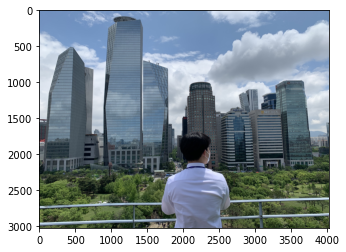

(662, 664, 3)


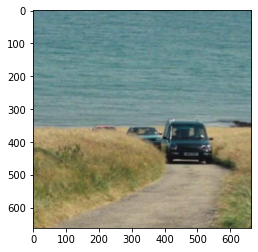

(720, 960, 3)


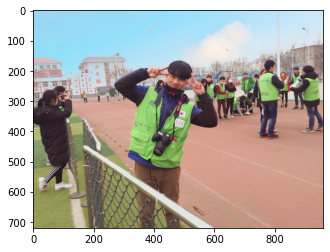

In [2]:
img_path_2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image(2).png'
img_kdb = cv2.imread(img_path_2) 
#
img_path_4 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image(4).png'
img_car = cv2.imread(img_path_4) 
#
img_path_5 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image(5).png'
img_move = cv2.imread(img_path_5) 



print(img_kdb.shape)
plt.imshow(cv2.cvtColor(img_kdb, cv2.COLOR_BGR2RGB))
plt.show()
#
print(img_car.shape)
plt.imshow(cv2.cvtColor(img_car, cv2.COLOR_BGR2RGB))
plt.show()
#
print(img_move.shape)
plt.imshow(cv2.cvtColor(img_move, cv2.COLOR_BGR2RGB))
plt.show()


In [3]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fd6a95bce50>)

In [4]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

### 1-1) 독사진

In [5]:
segvalues, output = model.segmentAsPascalvoc(img_path_2)

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

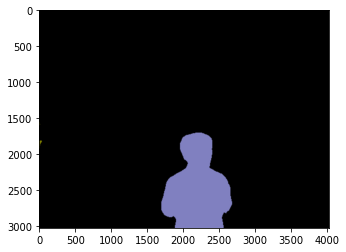

In [7]:
plt.imshow(output)
plt.show()

In [8]:
segvalues

{'class_ids': array([ 0,  6, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [9]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bus
person


In [10]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
colormap[15]

array([192, 128, 128])

In [12]:
seg_color = (128,128,192)

(3024, 4032)


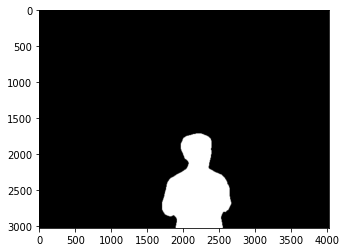

In [13]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

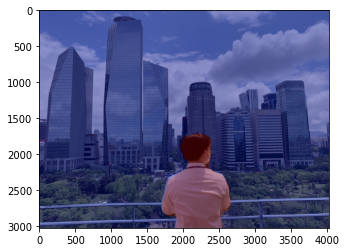

In [14]:
img_show = img_kdb.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

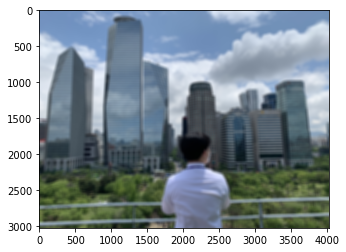

In [15]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_kdb_blur = cv2.blur(img_kdb, (50,50))  
plt.imshow(cv2.cvtColor(img_kdb_blur, cv2.COLOR_BGR2RGB))
plt.show()

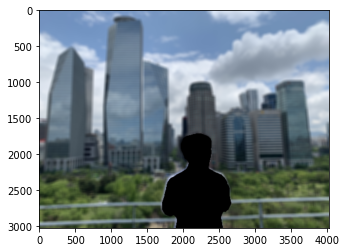

In [16]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_kdb_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

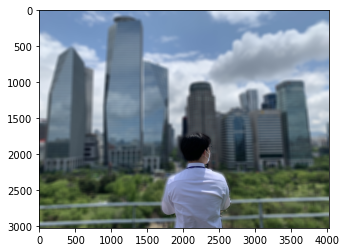

In [17]:
img_concat = np.where(img_mask_color==255, img_kdb, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 1-2) + 2) 사물

In [18]:
segvalues, output = model.segmentAsPascalvoc(img_path_4)

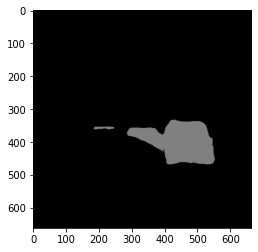

In [19]:
plt.imshow(output)
plt.show()

In [20]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
car


In [21]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [22]:
colormap[7]

array([128, 128, 128])

In [23]:
seg_color = (128,128,128)

(662, 664)


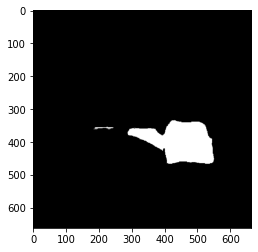

In [24]:
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

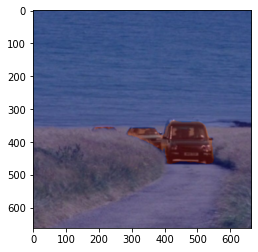

In [25]:
img_show = img_car.copy()

img_mask = seg_map.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

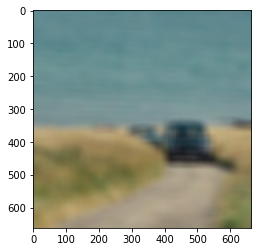

In [26]:
img_car_blur = cv2.blur(img_car, (30,30))  
plt.imshow(cv2.cvtColor(img_car_blur, cv2.COLOR_BGR2RGB))
plt.show()

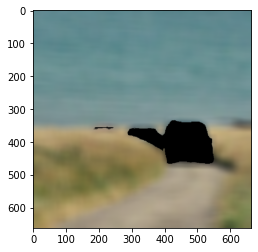

In [27]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_car_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

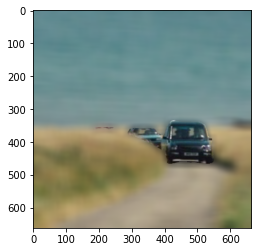

In [28]:
img_concat = np.where(img_mask_color==255, img_car, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 1-3) + 2) 단체사진

In [29]:
segvalues, output = model.segmentAsPascalvoc(img_path_5)

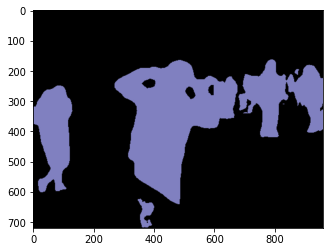

In [30]:
plt.imshow(output)
plt.show()

In [31]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [32]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [33]:
colormap[15]

array([192, 128, 128])

In [34]:
seg_color = (128, 128, 192)

(720, 960)


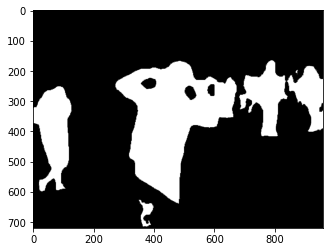

In [35]:
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

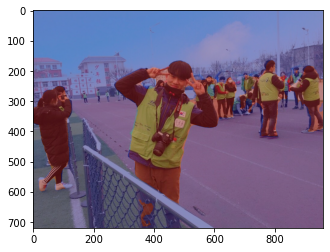

In [36]:
img_show = img_move.copy()

img_mask = seg_map.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

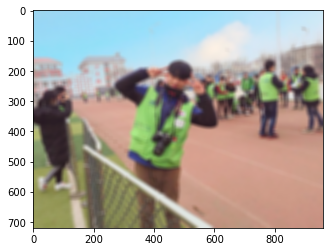

In [37]:
img_move_blur = cv2.blur(img_move, (15,15))  
plt.imshow(cv2.cvtColor(img_move_blur, cv2.COLOR_BGR2RGB))
plt.show()

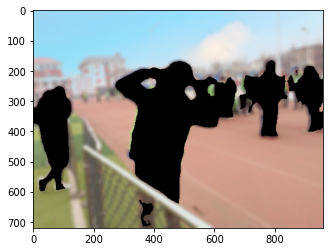

In [38]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_move_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

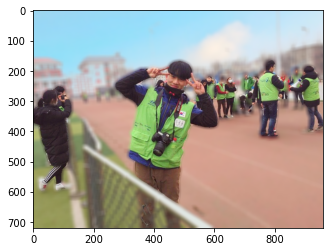

In [39]:
img_concat = np.where(img_mask_color==255, img_move, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 3) 배경 합성

(3024, 4032)


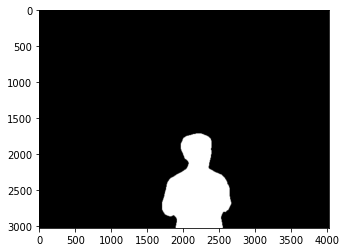

In [40]:
segvalues, output = model.segmentAsPascalvoc(img_path_2)
#
for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
#
seg_color = (128,128,192)
#
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

(1275, 1268, 3)


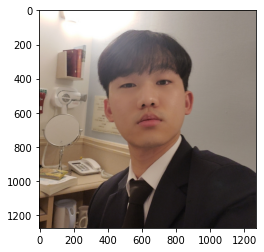

In [41]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

background
person


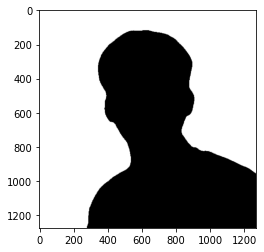

In [42]:
segvalues, output = model.segmentAsPascalvoc(img_path)

for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
    
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
    
colormap[15]
seg_color = (128,128,192)

seg_map = np.all(output==seg_color, axis=-1)

plt.imshow(seg_map, cmap='gray')

img_show = img_orig.copy()
img_mask = seg_map.astype(np.uint8) * 255
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
plt.imshow(cv2.cvtColor(img_bg_mask, cv2.COLOR_BGR2RGB))
plt.show()

In [43]:
resize_what = cv2.resize(img_orig, (1268, 1275))

In [44]:
resize_that = cv2.resize(img_kdb, (1268, 1275))

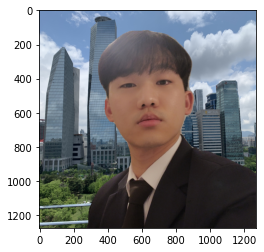

In [45]:
img_concat = np.where(img_mask_color==255, resize_what, resize_that)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

----------------------------------------------------------------------------------------------------------------------------------------

## Step 2. 사진에서 문제점 찾기



    세그멘테이션 기법으로는 오려내기처럼 아직 정확하게 지정개체만을 추출하지 못하고 선 형태로 대략적인 부분을 잡아내어 엉뚱한 부분까지 인식이 되는 결점이 있습니다.  

    또한, 특정 부분을 추출하려고 했으나 사진처럼 모두를 인식합니다.

In [49]:
img_path_7 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image_miss.png'
img_miss = cv2.imread(img_path_7)

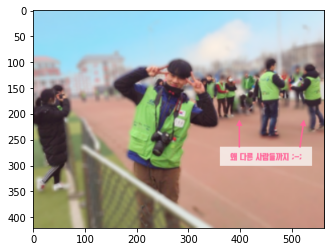

In [50]:
plt.imshow(cv2.cvtColor(img_miss, cv2.COLOR_BGR2RGB))
plt.show()

----------------------------------------------------------------------------------------------------------------------------------------

## Step 3. 해결 방법 제안

    1. 3D Depth Camera 활용하기
    카메라 2개를 통해 생성한 3d 영상으로 인물모드를 더 정확하게 만들 수 있을까요? 우리는 카메라 1대가 찍은 영상에서 semantic segmentation을 시도하였고, 그 결과가 정확하지 않았습니다. 요즘의 스마트폰이 카메라 렌즈를 2개나 달고 생산되는 이유가 여기에 있습니다.


    2. 깊이 영상(Depth image) 활용하기
    왜 꼭 카메라가 2개여야 할까? Struct2Depth 라는 기법을 소개한 Google Brain의 논문에 따르면, 명확하게 depth에 따른 물체인식을 보여 줍니다. 이는 LiDAR가 없이도 아주 정확한 segmentation을 동반한 depth sensor가 가능하다는 것을 증명합니다.


    3. IR(적외선)을 활용한 사례
    구글 pixel4에 IR 카메라가 달려있는데, 이를 통해 보다 멋진 3d depth sensing이 가능하다고 합니다.

----------------------------------------------------------------------------------------------------------------------------------------

## 회고

    내가 틀렸다...CV가 재밌다...역시..

이번 프로젝트에서는 'DeepLabV3+' 모델을 이용해 아웃포커싱 기법 즉, 인물사진 모드로 찍은 것 같은 사진을 제작해 보았습니다. 결론부터 적자면 독사진, 단체사진, 사물 사진 모두가 잘 완성되었습니다. 나아가 이를 활용한 크로마키 합성까지 할 수 있었습니다.

제목에서 알 수 있듯 CV가 확실히 더 재밌는 것같습니다. 그동안 NL 쪽으로 생각하고 선택해야지 싶었는데, CV의 맛을 알아버린 것같습니다. 물론, 제가 모르는 재밌는 NL의 분야도 있을 것같습니다. 빨리 저의 편견을 깨줄 NL이 나타났으면 합니다.

다시 본론으로 돌아와서 사진 2가지에 대해서 말씀드리고자 합니다. 저는 일부러 모델에 어려운 사진을 보여줬다고 생각합니다. 2번째 car 사진을 보면 자동차가 멀리있을 뿐만 아니라, 아주 작고 가려져 있는 차들도 있었기 때문입니다. 제가 몰랐던 자동차까지 캐치해내서 인식해 신기했습니다. 또한, 단체 사진을 통해서 여러 사람들을 인식해서 좋은 점도 있었습니다. 그러나, 제 자신만을 위한 아웃포커싱이 안되어서 아쉬운 점이 있습니다. 

추가적으로 수행한 합성에서는 어려움을 겪었습니다..이 부분에 대해서는 조원들과 생각을 공유했는데, 모두 이해한 것이 달랐기 때문입니다. 조원 중에서 "크로마키처럼 연두색 혹은 파란색 배경을 입히고 배경 사진을 가져와 합성해야 한다"와 "그냥 배경 사진에 합성하면 된다" 등이 있었씁니다. 그런데 저는 배운 것들로 충분히 할 수 있겠다 생각하였고, 이에 하나의 사진에서 사람만 짤라낸 배경과 다른 사진에서는 배경만 짤라낸 사람을 뽑아냈습니다. 이 아이디어를 실현시키려다 보니 처음에 깔끔하게 파라미터를 못한게 아쉬웠습니다. 그래도 결국은 원하는 대로 잘 나와서 좋았고, 다음에는 잘 정리된 project를 만들어야겠다는 배움을 얻었습니다.